In [1]:
from utils import *
import os
from grid2op.utils import ScoreL2RPN2020
from l2rpn_baselines.utils import GymEnvWithRecoWithDN
import numpy as np
import re
import copy

2022-05-23 17:32:11.224268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-23 17:32:11.224293: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/boguslawskieva/miniconda3/envs/baselines_dev/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def create_bar_plot(dict_ts_survived, dn_ts_survived, reco_ts_survived, path=None):
  scenarios = [i+1 for i in range(len(dn_ts_survived))] + ["Mean"]
  d = {"Scenarios": scenarios,
       "Do Nothing": np.append(dn_ts_survived, dn_ts_survived.mean()),
       "Reco": np.append(reco_ts_survived, reco_ts_survived.mean())}

  for key, value in dict_ts_survived.items():
    dict_ts_survived[key] = np.append(value, value.mean())

  d.update(dict_ts_survived)
       
  df = pd.DataFrame(d)
  tidy = df.melt(id_vars="Scenarios").rename(columns=str.title)
  tidy.rename(columns={"Value": "Survived steps", "Variable": "Agents"}, inplace=True)
  fig, ax1 = plt.subplots(figsize=(10, 5))
  sns.barplot(x="Scenarios", y="Survived steps", hue="Agents", data=tidy, palette=("magma"), ax=ax1)
  ax1.axhline(2017, color="black", label="Maximum time steps")
  plt.legend()
  sns.despine(fig)
  if path is not None:
    plt.savefig(path)
  plt.show()

In [4]:
import seaborn as sns

def create_box_plot(dict_ts_survived, dn_ts_survived, reco_ts_survived, path=None):
  d = {"Scenarios": [],
       "Agents": [],
       "Survived steps": []}

  for i, v in enumerate(dn_ts_survived):
    d["Scenarios"].append(i)
    d["Agents"].append("DN")
    d["Survived steps"].append(v)
  
  for i, v in enumerate(reco_ts_survived):
    d["Scenarios"].append(i)
    d["Agents"].append("Reco")
    d["Survived steps"].append(v)

  for key, scenarios in dict_ts_survived.items():
    for i, values in enumerate(scenarios):
      for v in values:
        d["Scenarios"].append(i)
        d["Agents"].append(key)
        d["Survived steps"].append(v)

  df = pd.DataFrame(d)

  fig, ax1 = plt.subplots(figsize=(10, 5))
  sns.boxplot(x="Scenarios", y="Survived steps", hue="Agents", data=df, palette=("magma"), ax=ax1)
  ax1.axhline(2017, color="black", label="Maximum time steps")
  plt.legend()
  sns.despine(fig)
  if path is not None:
    plt.savefig(path)
  plt.show()

### Parameters of the agents to evaluate

In [5]:
save_path = "./saved_model/"
ENV_NAME = "l2rpn_wcci_2022_dev"
SCOREUSED = ScoreL2RPN2020
gymenv_class = GymEnvWithRecoWithDN
verbose = False
p = Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True # It causes errors during training
  
train_args = {}
train_args["gymenv_kwargs"] = {"safe_max_rho": 0.2}

values_to_test = np.array([1e-5, 3e-5, 1e-4])
var_to_test = "learning_rate"

agents_names = [d for d in os.listdir(save_path) if os.path.isdir(save_path + d)]
agents_names

['before_adding_attacks',
 'GymEnvWithRecoWithDN_2022-05-18_13-47_learning_rate_0',
 'before_full_normalization',
 'GymEnvWithRecoWithDN_2022-05-20_18-52_learning_rate_0',
 'old']

In [139]:
def filter_chronics(x):
  list_chronics = ["2050-01-03_31",
                   "2050-02-21_31",
                   "2050-03-07_31",
                   "2050-04-18_31"] # Names of chronics to keep
  p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
  return re.match(p, x) is not None

# filter_chronics = None

env_name_used = ENV_NAME + '_val' if filter_chronics is None else ENV_NAME
nb_scenario = 59 if filter_chronics is None else 4

### Evaluation

In [100]:
agents_names = ['GymEnvWithRecoWithDN_2022-05-20_18-52_learning_rate_0']

# agents_names = [el for el in os.listdir(save_path) if re.match(r'GymEnv.*', el) is not None]

total_results = np.zeros((len(agents_names), nb_scenario, 3))
for i, agent_name in enumerate(agents_names):
  results = eval_agent(env_name_used,
            nb_scenario,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs=train_args["gymenv_kwargs"] if var_to_test!="gymenv_kwargs" else values_to_test[i],
            param=p,
            filter_fun=filter_chronics
            )
  for k in range(3):
    total_results[i, :, k]=np.array(results[k])
  # print(results)

In [102]:
# Agregation des initialisations si il y en a plusieurs

# nb_init = 4
nb_init = 1


if nb_init > 2:
    total_results_mean = np.zeros((len(agents_names)//nb_init, nb_scenario, 3))
    total_results_std = np.zeros((len(agents_names)//nb_init, nb_scenario, 3))
    total_results_best = np.zeros((total_results.shape[0], total_results.shape[1], 2))
    total_results_best_mean = np.zeros((len(agents_names)//nb_init, 2))
    dict_ts_survived_init = {}
    for i_val in range(total_results_mean.shape[0]):
        pattern = re.compile('.*' + str(i_val) + '$')
        index = np.where([re.match(pattern, el) is not None for el in agents_names])[0]
        dict_ts_survived_init.update({f"Agent_{i_val}" : total_results[index, :, 0].T})
        total_results_mean[i_val] = np.mean(total_results[index], axis=0)
        total_results_std[i_val] = np.std(total_results[index], axis=0)
        total_results_best[index] = np.mean(total_results[index][:, :, [0]] > total_results[index][:, :, [1,2]], axis=1)
        total_results_best_mean[i_val] = np.mean(total_results_best[index], axis=0)
        
else:
    total_results_mean = copy.deepcopy(total_results)
    total_results_best_mean = np.mean(total_results[:, :, [0]] > total_results[:, :, [1,2]], axis=1)
    dict_ts_survived_scenario = {}
    for i_val in range(total_results_mean.shape[0]):
        dict_ts_survived_scenario.update({f"Agent_{i_val}" : total_results[[i_val], :, 0]})
    dict_ts_survived_scenario.update({"DN_Agent": [total_results_mean[0, :, 1]], "Reco_Agent": [total_results_mean[0, :, 2]]})


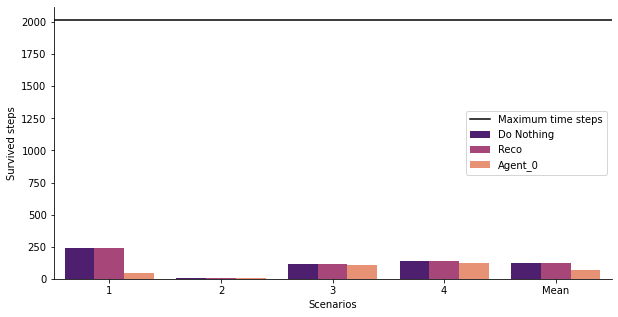

In [103]:
create_bar_plot({f"Agent_{i}" : total_results_mean[i, :, 0] for i in range(total_results_mean.shape[0])},
                    total_results_mean[0, :, 1], 
                    total_results_mean[0, :, 2])

if nb_init > 1:
    create_bar_plot({f"Agent_{i}" : total_results_std[i, :, 0] for i in range(total_results_std.shape[0])},
                    total_results_std[0, :, 1], 
                    total_results_std[0, :, 2])
    create_box_plot(dict_ts_survived_init, total_results_mean[0, :, 1], total_results_mean[0, :, 2])

In [104]:
if filter_chronics is None:
    create_box_plot(dict_ts_survived_scenario, [],  [])

In [105]:
for i in range(total_results_best_mean.shape[0]):
    print(f"Agent_{i} has been better than DN_Agent for {total_results_best_mean[i,0]*100} % of the scenarios")
    print(f"Agent_{i} has been better than Reco_Agent for {total_results_best_mean[i,1]*100} % of the scenarios")

Agent_0 has been better than DN_Agent for 0.0 % of the scenarios
Agent_0 has been better than Reco_Agent for 0.0 % of the scenarios


## Varying seeds

In [128]:
from grid2op.Agent import RecoPowerlineAgent, DoNothingAgent
from grid2op.Runner import Runner
from examples.ppo_stable_baselines.C_evaluate_trained_model import load_agent
from grid2op.Chronics import MultifolderWithCache
from tqdm import tqdm

with open("./preprocess_obs.json", "r", encoding="utf-8") as f:
    obs_space_kwargs = json.load(f)
with open("./preprocess_act.json", "r", encoding="utf-8") as f:
    act_space_kwargs = json.load(f)

In [167]:
def vary_seeds(agents_names, env_name, save_path, nb_scenario, gymenv_class, gymenv_kwargs={}, nb_init_seeds=3, filter_chronics=None):
    env = grid2op.make(env_name,
                    reward_class=CustomReward2,
                    backend=LightSimBackend(),
                    chronics_class=MultifolderWithCache,
                    param=p)


    agents_list = [(load_agent(env, 
                                load_path=save_path, 
                                name=agent_name, 
                                gymenv_class=gymenv_class, 
                                gymenv_kwargs=gymenv_kwargs,
                                obs_space_kwargs=obs_space_kwargs,
                                act_space_kwargs=act_space_kwargs), agent_name) for agent_name in agents_names]
    agents_list.append((DoNothingAgent(env.action_space), "DoNothingAgent"))
    agents_list.append((RecoPowerlineAgent(env.action_space), "RecoPowerlineAgent"))

    max_int = np.iinfo(dt_int).max
    env_seeds_list=[np.random.randint(low=0,
                                high=max_int,
                                size=nb_scenario,
                                dtype=dt_int) for _ in range(nb_init_seeds)]

    results_list = []
    results_dict = {}
    for agent, agent_name in agents_list:
        results_dict[agent_name]=[]
        for env_seeds in tqdm(env_seeds_list, desc = agent_name):
            results = eval_agent(env_name,
                        nb_scenario,
                        agent_name,
                        save_path,
                        SCOREUSED,
                        gymenv_class,
                        verbose=False,
                        gymenv_kwargs=gymenv_kwargs,
                        param=p,
                        filter_fun=filter_chronics,
                        env_seeds=env_seeds,
                        my_agent=agent)
            results_dict[agent_name].append(results[0])
            results_list.append([env_seeds, agent_name, results[0]])
    results_dict = {k: np.array(v).T for k,v in results_dict.items()}
    return results_dict

In [ ]:
results_dict = vary_seeds(agents_names=agents_names,
                            env_name =env_name_used, 
                            save_path=save_path, 
                            gymenv_class=gymenv_class,
                            gymenv_kwargs=train_args["gymenv_kwargs"] if var_to_test!="gymenv_kwargs" else values_to_test[i],
                            nb_scenario=nb_scenario,
                            filter_chronics=filter_chronics,
                            nb_init_seeds=20
                            )

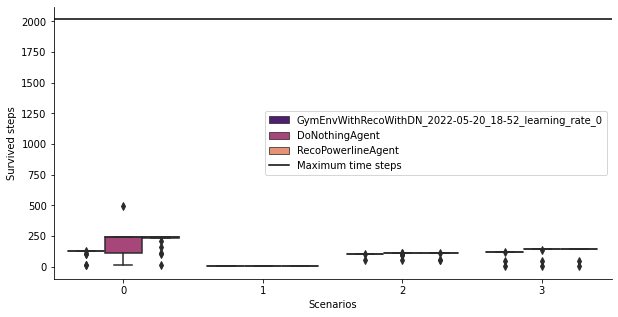

({'GymEnvWithRecoWithDN_2022-05-20_18-52_learning_rate_0': array([[127, 127, 127,  16,  12, 127, 127, 127, 127, 127, 127, 126, 104,
          127, 127, 127, 127, 105, 127, 127],
         [  3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
            3,   3,   3,   3,   3,   3,   3],
         [105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105, 105,  59,
          105, 105, 105, 105, 105, 107, 105],
         [120, 120,   8,  46, 120, 120, 120, 120, 119, 120, 120, 120, 120,
          120, 120, 120, 120, 120, 120, 120]]),
  'DoNothingAgent': array([[495, 106, 239,  16, 109, 239, 239, 239, 239, 239, 239, 109, 109,
          160, 239, 239, 127, 103, 213, 239],
         [  3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
            3,   3,   3,   3,   3,   3,   3],
         [114, 115, 115, 115, 115, 116, 115, 115, 115, 115,  95,  95,  59,
          115, 115, 115, 115, 115, 115, 115],
         [142, 142,  10,  44, 142, 142, 142, 142, 142, 142, 142, 142, 142,
 

In [169]:
results_dict, create_box_plot(results_dict, [], [])